In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from glob import glob
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.applications import InceptionV3, VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Concatenate, Input, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Constants
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 1e-4

In [4]:
def show_samples(normal_path, potholes_path, num_samples=5):
    """
    Display sample images from both classes
    """
    plt.figure(figsize=(15, 5))
    
    # Show normal road samples
    normal_images = glob(os.path.join(normal_path, '*.jpg'))[:num_samples]
    for i, img_path in enumerate(normal_images):
        img = Image.open(img_path)
        plt.subplot(2, num_samples, i + 1)
        plt.imshow(img)
        plt.title(f"Normal {i+1}")
        plt.axis('off')
    
    # Show pothole samples
    potholes_images = glob(os.path.join(potholes_path, '*.jpg'))[:num_samples]
    for i, img_path in enumerate(potholes_images):
        img = Image.open(img_path)
        plt.subplot(2, num_samples, num_samples + i + 1)
        plt.imshow(img)
        plt.title(f"Pothole {i+1}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

In [5]:
def preprocess_image(img):
    """
    Preprocess a single image
    """
    if isinstance(img, str):
        img = cv2.imread(img)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    img = cv2.resize(img, IMG_SIZE)
    img = img.astype(np.float32) / 255.0
    return img

In [6]:
def load_and_preprocess_dataset(normal_path, potholes_path):
    """
    Load and preprocess the entire dataset
    """
    images = []
    labels = []
    
    # Load normal road images
    for filename in os.listdir(normal_path):
        try:
            img_path = os.path.join(normal_path, filename)
            img = preprocess_image(img_path)
            images.append(img)
            labels.append(0)
        except Exception as e:
            print(f"Error loading {filename}: {str(e)}")
    
    # Load pothole images
    for filename in os.listdir(potholes_path):
        try:
            img_path = os.path.join(potholes_path, filename)
            img = preprocess_image(img_path)
            images.append(img)
            labels.append(1)
        except Exception as e:
            print(f"Error loading {filename}: {str(e)}")
    
    return np.array(images), np.array(labels)

In [7]:
def create_data_generators(X_train, y_train, X_test, y_test):
    """
    Create train and validation data generators
    """
    train_datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    
    train_generator = train_datagen.flow(
        X_train, y_train,
        batch_size=BATCH_SIZE
    )
    
    # No augmentation for validation data
    test_generator = ImageDataGenerator().flow(
        X_test, y_test,
        batch_size=BATCH_SIZE
    )
    
    return train_generator, test_generator

In [8]:
def create_ensemble_model():
    """
    Create the ensemble model combining InceptionV3 and VGG16
    """
    # Input layer
    input_layer = Input(shape=(*IMG_SIZE, 3))
    
    # Load and freeze pre-trained models
    inception = InceptionV3(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))
    vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))
    
    for layer in inception.layers:
        layer.trainable = False
    for layer in vgg16.layers:
        layer.trainable = False
    
    # Get features from both models
    inception_features = inception(input_layer)
    vgg16_features = vgg16(input_layer)
    
    # Flatten features
    flatten_inception = Flatten()(inception_features)
    flatten_vgg16 = Flatten()(vgg16_features)
    
    # Merge features
    merged = Concatenate()([flatten_inception, flatten_vgg16])
    
    # Dense layers with batch normalization and dropout
    x = Dense(512, activation='relu')(merged)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    
    # Output layer
    output_layer = Dense(1, activation='sigmoid')(x)
    
    # Create and compile model
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC()]
    )
    
    return model

In [9]:
def plot_training_history(history):
    """
    Plot training history
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    
    # Plot loss
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()


In [10]:
def evaluate_model(model, X_test, y_test):
    """
    Evaluate the model and display results
    """
    # Get predictions
    y_pred = model.predict(X_test)
    y_pred_classes = (y_pred > 0.5).astype(int)
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_classes))
    
    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [11]:
def main():
    # Paths to dataset
    normal_path = 'Dataset/normal'
    potholes_path = 'Dataset/potholes'
    
    # Show sample images
    show_samples(normal_path, potholes_path)
    
    # Load and preprocess data
    print("Loading and preprocessing data...")
    X, y = load_and_preprocess_dataset(normal_path, potholes_path)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.2,
        random_state=42,
        stratify=y
    )
    
    # Create data generators
    train_generator, test_generator = create_data_generators(
        X_train, y_train,
        X_test, y_test
    )
    
    # Create and compile model
    print("Creating model...")
    model = create_ensemble_model()
    
    # Define callbacks
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            patience=10,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ModelCheckpoint(
            'best_model.h5',
            save_best_only=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            factor=0.2,
            patience=5
        )
    ]
    
    # Train model
    print("Training model...")
    history = model.fit(
        train_generator,
        epochs=EPOCHS,
        validation_data=test_generator,
        callbacks=callbacks
    )
    
    # Plot training history
    plot_training_history(history)
    
    # Evaluate model
    print("Evaluating model...")
    evaluate_model(model, X_test, y_test)
    
    # Save final model
    model.save('final_pothole_detection_model.h5')
    print("Model saved as 'final_pothole_detection_model.h5'")

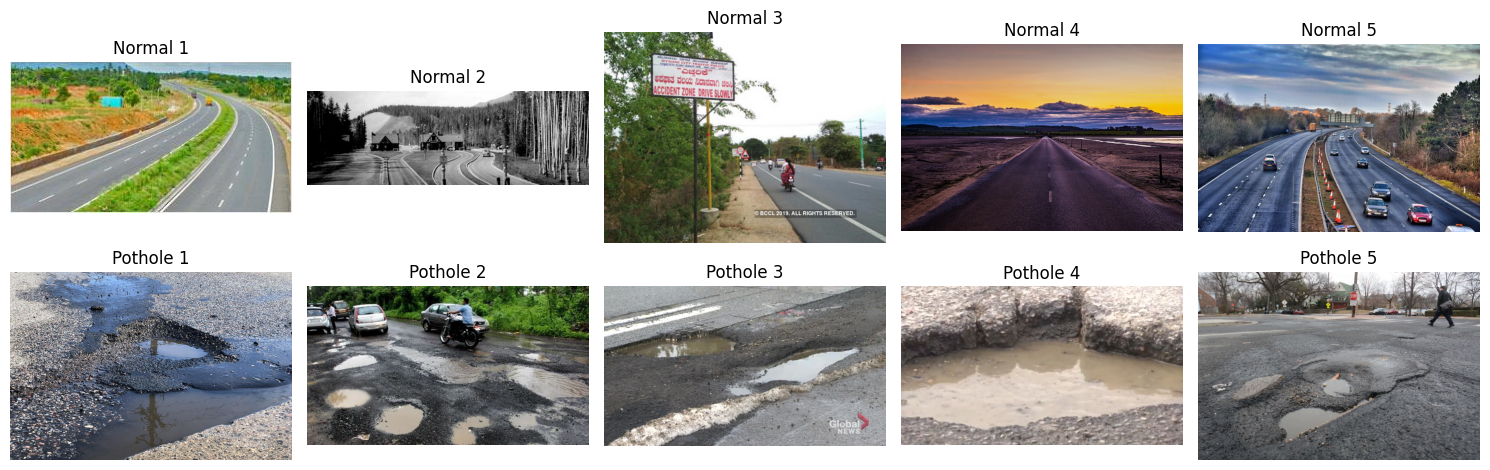

Loading and preprocessing data...
Error loading 226.jpg: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'

Creating model...
Training model...
Epoch 1/50
17/17 [==============================] - 32s 932ms/step - loss: 0.3235 - accuracy: 0.8750 - auc: 0.9405 - val_loss: 0.3775 - val_accuracy: 0.8971 - val_auc: 0.9857 - lr: 1.0000e-04
Epoch 2/50
17/17 [==============================] - 10s 557ms/step - loss: 0.1128 - accuracy: 0.9614 - auc: 0.9920 - val_loss: 0.2182 - val_accuracy: 0.9485 - val_auc: 0.9857 - lr: 1.0000e-04
Epoch 3/50
17/17 [==============================] - 10s 582ms/step - loss: 0.1091 - accuracy: 0.9706 - auc: 0.9920 - val_loss: 0.1740 - val_accuracy: 0.9706 - val_auc: 0.9852 - lr: 1.0000e-04
Epoch 4/50
17/17 [==============================] - 10s 583ms/step - loss: 0.1027 - accuracy: 0.9651 - auc: 0.9931 - val_loss: 0.1443 - val_accuracy: 0.9706 - val_auc: 

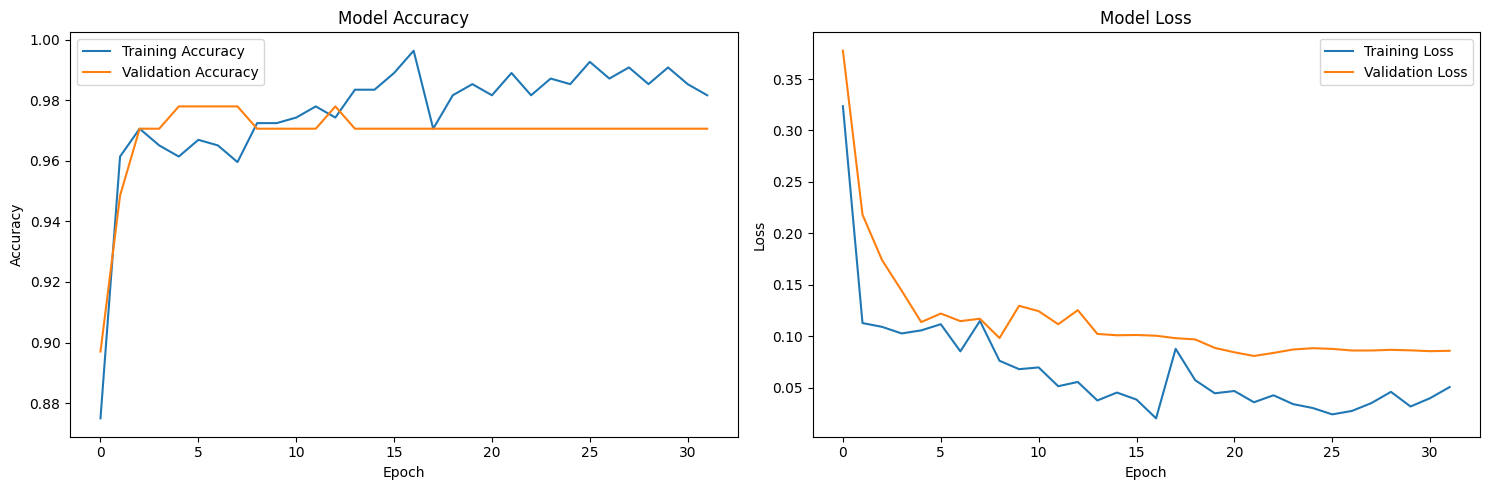

Evaluating model...
5/5 [==============================] - 5s 879ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.97        70
           1       0.96      0.98      0.97        66

    accuracy                           0.97       136
   macro avg       0.97      0.97      0.97       136
weighted avg       0.97      0.97      0.97       136



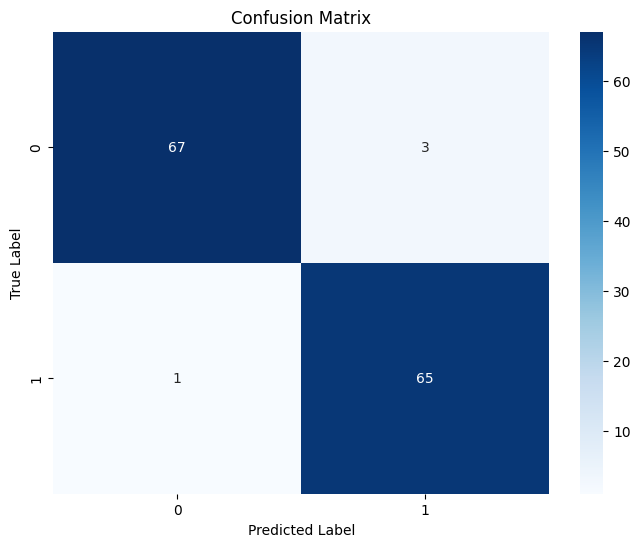

Model saved as 'final_pothole_detection_model.h5'


In [12]:
if __name__ == "__main__":
    main()